In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [2]:
torch.manual_seed(1307)

In [3]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

def none_transform():
    transforms = [
        LabelSelect(label_id=1),
        lambda x, y: (x, y.squeeze().type(torch.long))
    ]
    return PairedCompose(transforms)

def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [4]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [5]:
ckpt_dir = None
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]]
# domains = [ wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]

train_proportion = 0.7
test_proportion = 0.15
validation_proportion = 0.15
seed = 3407

In [6]:
### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size

In [7]:
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [8]:
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [9]:
datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_dataset_3d, val_dataset_3d, test_dataset_3d]]

In [10]:
train_dataset, val_dataset, test_dataset = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

In [11]:
val_dataset[0][1].shape

torch.Size([224, 160])

In [12]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 30, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [13]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [14]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [15]:
def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

In [16]:
class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()   

In [17]:
import pyro
from torch.distributions.multivariate_normal import _batch_mahalanobis, _batch_mv
from torch.distributions.utils import _standard_normal, lazy_property
from pyro.distributions.torch_distribution import TorchDistribution

import math

import torch
from torch.distributions import constraints
from torch.distributions.utils import lazy_property

from pyro.distributions.torch import Chi2
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.util import broadcast_shape

def _batch_capacitance_tril(W, D):
    r"""
    Computes Cholesky of :math:`I + W.T @ inv(D) @ W` for a batch of matrices :math:`W`
    and a batch of vectors :math:`D`.
    """
    m = W.size(-1)
    Wt_Dinv = W.mT / D.unsqueeze(-2)
    K = torch.matmul(Wt_Dinv, W).contiguous()
    K.view(-1, m * m)[:, ::m + 1] += 1  # add identity matrix to K
    return torch.linalg.cholesky(K)


def _batch_lowrank_logdet(W, D, capacitance_tril):
    r"""
    Uses "matrix determinant lemma"::
        log|W @ W.T + D| = log|C| + log|D|,
    where :math:`C` is the capacitance matrix :math:`I + W.T @ inv(D) @ W`, to compute
    the log determinant.
    """
    return 2 * capacitance_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1) + D.log().sum(-1)


def _batch_lowrank_mahalanobis(W, D, x, capacitance_tril):
    r"""
    Uses "Woodbury matrix identity"::
        inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D),
    where :math:`C` is the capacitance matrix :math:`I + W.T @ inv(D) @ W`, to compute the squared
    Mahalanobis distance :math:`x.T @ inv(W @ W.T + D) @ x`.
    """
    Wt_Dinv = W.mT / D.unsqueeze(-2)
    Wt_Dinv_x = _batch_mv(Wt_Dinv, x)
    mahalanobis_term1 = (x.pow(2) / D).sum(-1)
    mahalanobis_term2 = _batch_mahalanobis(capacitance_tril, Wt_Dinv_x)
    return mahalanobis_term1 - mahalanobis_term2

class LowRankMultivariateStudentT_V3(TorchDistribution):
    """
    Creates a multivariate t distribution with covariance matrix having a low-rank
    form parameterized by :attr:`cov_factor` and :attr:`cov_diag`::
        covariance_matrix = cov_factor @ cov_factor.T + cov_diag
    
    Args:
    
    df (Tensor): degrees of freedom of the distribution
    loc (Tensor): mean of the distribution with shape `batch_shape + event_shape`
    cov_factor (Tensor): factor part of low-rank form of covariance matrix with shape
        `batch_shape + event_shape + (rank,)`
    cov_diag (Tensor): diagonal part of low-rank form of covariance matrix with shape
        `batch_shape + event_shape`

    Note:
        The computation for determinant and inverse of covariance matrix is avoided when
        `cov_factor.shape[1] << cov_factor.shape[0]` thanks to `Woodbury matrix identity
        <https://en.wikipedia.org/wiki/Woodbury_matrix_identity>`_ and
        `matrix determinant lemma <https://en.wikipedia.org/wiki/Matrix_determinant_lemma>`_.
        Thanks to these formulas, we just need to compute the determinant and inverse of
        the small size "capacitance" matrix::

            capacitance = I + cov_factor.T @ inv(cov_diag) @ cov_factor
    """
    
    arg_constraints = {"df": constraints.positive,
                       "loc": constraints.real_vector,
                       "cov_factor": constraints.independent(constraints.real, 2),
                       "cov_diag": constraints.independent(constraints.positive, 1)}
    
    support = constraints.real_vector
    has_rsample = True
    
    def __init__(self, df, loc, cov_factor, cov_diag, validate_args=None):
        if loc.dim() < 1:
            raise ValueError("loc must be at least one-dimensional.")
        event_shape = loc.shape[-1:]
        if cov_factor.dim() < 2:
            raise ValueError("cov_factor must be at least two_dimensional")
        if cov_factor.shape[-2:-1] != event_shape:
            raise ValueError("cov_factor must be a batch of matrices with shape {} x m".format(event_shape[0]))
        if cov_diag.shape[-1:] != event_shape:
            raise ValueError("cov_diag must be a batch of vectors with shape {}".format(event_shape))
            
        if not isinstance(df, torch.Tensor):
            df = loc.new_tensor(df)
            
        loc_ = loc.unsqueeze(-1)
        cov_diag_ = cov_diag.unsqueeze(-1)
        try:
            loc_, self.cov_factor, cov_diag_ = torch.broadcast_tensors(loc_, cov_factor, cov_diag_)
        except RuntimeError as e:
            raise ValueError("Incompatible batch shapes: loc {}, cov_factor {}, cov_diag {}"
                             .format(loc.shape, cov_factor.shape, cov_diag.shape)) from e
        
        self.loc = loc_[..., 0]
        self.cov_diag = cov_diag_[..., 0]
        batch_shape = self.loc.shape[:-1]
        self.df = df.expand(batch_shape)

        self._unbroadcasted_cov_factor = cov_factor
        self._unbroadcasted_cov_diag = cov_diag
        self._capacitance_tril = _batch_capacitance_tril(cov_factor, cov_diag)
        
        self._chi2 = Chi2(self.df)
        
        super().__init__(batch_shape, event_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LowRankMultivariateNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        loc_shape = batch_shape + self.event_shape
        new.df = self.df = df.expand(loc_shape)
        new.loc = self.loc.expand(loc_shape)
        new._chi2 = self._chi2.expand(loc_shape)
        new.cov_diag = self.cov_diag.expand(loc_shape)
        new.cov_factor = self.cov_factor.expand(loc_shape + self.cov_factor.shape[-1:])
        new._unbroadcasted_cov_factor = self._unbroadcasted_cov_factor
        new._unbroadcasted_cov_diag = self._unbroadcasted_cov_diag
        new._capacitance_tril = self._capacitance_tril
        super(LowRankMultivariateStudentT_V2, new).__init__(batch_shape,
                                                       self.event_shape,
                                                       validate_args=False)
        new._validate_args = self._validate_args
        return new
    
    @lazy_property
    def scale_tril(self):
        # The following identity is used to increase the numerically computation stability
        # for Cholesky decomposition (see http://www.gaussianprocess.org/gpml/, Section 3.4.3):
        #     W @ W.T + D = D1/2 @ (I + D-1/2 @ W @ W.T @ D-1/2) @ D1/2
        # The matrix "I + D-1/2 @ W @ W.T @ D-1/2" has eigenvalues bounded from below by 1,
        # hence it is well-conditioned and safe to take Cholesky decomposition.
        n = self._event_shape[0]
        cov_diag_sqrt_unsqueeze = self._unbroadcasted_cov_diag.sqrt().unsqueeze(-1)
        Dinvsqrt_W = self._unbroadcasted_cov_factor / cov_diag_sqrt_unsqueeze
        K = torch.matmul(Dinvsqrt_W, Dinvsqrt_W.mT).contiguous()
        K.view(-1, n * n)[:, ::n + 1] += 1  # add identity matrix to K
        scale_tril = cov_diag_sqrt_unsqueeze * torch.linalg.cholesky(K)
        return scale_tril.expand(self._batch_shape + self._event_shape + self._event_shape)

    @lazy_property
    def covariance_matrix(self):
        # NB: this is not covariance of this distribution;
        # the actual covariance is df / (df - 2) * covariance_matrix
        covariance_matrix = (torch.matmul(self._unbroadcasted_cov_factor,
                                          self._unbroadcasted_cov_factor.mT)
                             + torch.diag_embed(self._unbroadcasted_cov_diag))
        return covariance_matrix.expand(self._batch_shape + self._event_shape +
                                        self._event_shape)

    @lazy_property
    def precision_matrix(self):
        # We use "Woodbury matrix identity" to take advantage of low rank form::
        #     inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D)
        # where :math:`C` is the capacitance matrix.
        Wt_Dinv = (self._unbroadcasted_cov_factor.mT
                   / self._unbroadcasted_cov_diag.unsqueeze(-2))
        A = torch.linalg.solve_triangular(self._capacitance_tril, Wt_Dinv, upper=False)
        precision_matrix = torch.diag_embed(self._unbroadcasted_cov_diag.reciprocal()) - A.mT @ A
        return precision_matrix.expand(self._batch_shape + self._event_shape +
                                       self._event_shape)
    
    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        #X = torch.empty(shape, dtype=self.df.dtype, device=self.df.device).normal_()
        Z = self._chi2.rsample(sample_shape)
        #Y = X * torch.rsqrt(Z / self.df).unsqueeze(-1)
        #return self.loc + self.scale_tril.matmul(Y.unsqueeze(-1)).squeeze(-1)
        
        W_shape = shape[:-1] + self.cov_factor.shape[-1:]
        eps_W = _standard_normal(W_shape, dtype=self.loc.dtype, device=self.loc.device)
        eps_D = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        
        frac = torch.rsqrt(Z / self.df).unsqueeze(-1)
        Yeps_W = eps_W * frac
        Yeps_D = eps_D * frac
        return (self.loc + _batch_mv(self._unbroadcasted_cov_factor, Yeps_W)
                + self._unbroadcasted_cov_diag.sqrt() * Yeps_D)
        


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.loc.size(-1)
        diff = (value - self.loc)
        y = _batch_lowrank_mahalanobis(self._unbroadcasted_cov_factor,
                                       self._unbroadcasted_cov_diag,
                                       diff,
                                       self._capacitance_tril)
        
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        Z = (
            log_det * 0.5
            + 0.5 * n * self.df.log()
            + 0.5 * n * math.log(math.pi)
            + torch.lgamma(0.5 * self.df)
            - torch.lgamma(0.5 * (self.df + n))
        )
        return -0.5 * (self.df + n) * torch.log1p(y / self.df) - Z


    @property
    def mean(self):
        m = self.loc.clone()
        m[self.df <= 1, :] = float("nan")
        return m

    @property
    def variance(self):
        m = self.scale_tril.pow(2).sum(-1) * (self.df / (self.df - 2)).unsqueeze(-1)
        m[(self.df <= 2) & (self.df > 1), :] = float("inf")
        m[self.df <= 1, :] = float("nan")
        return m

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as transforms

class HmResBlock(nn.Module):
    def __init__(self, channels, p):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=7, stride=1, dilation=2, padding='same')
        self.dropout1 = nn.Dropout2d(p)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, dilation=2, padding='same')
        self.norm2 = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        out = out + identity
        
        return out
    
class DownBlock(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.conv = nn.Conv2d(ins, outs, kernel_size=3, stride=2, dilation=1, padding=1)
        self.norm = nn.InstanceNorm2d(outs)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        return self.activ(self.norm(self.conv(x)))

class HmUpsampBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, dilation=1, padding='same')
        self.norm = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode='bilinear')
        return self.activ(self.norm(self.conv(out)))
        

class HmFeatureBlock(nn.Module):
    def __init__(self, ins):
        super().__init__()
        self.conv1 = nn.Conv2d(ins, ins//2, kernel_size=3, stride=1, dilation=2, padding='same')
        self.activ = nn.ReLU()
        self.norm1 = nn.InstanceNorm2d(ins)
        self.conv2 = nn.Conv2d(ins//2, ins//2, kernel_size=1, stride=1, dilation=1)
        self.norm2 = nn.InstanceNorm2d(ins)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        return out
    
class HyperMapREDO(nn.Module):
    def __init__(self,dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, outchannels=2):
        super().__init__()
        
        
        # input layer
        self.conv_first = nn.Conv2d(inchannels, encoder_sizes[0], kernel_size=5, stride=1, dilation=1, padding='same')
        self.activ = nn.ReLU()
        
        # encoder section
        l = len(encoder_sizes) - 1
        self.down_blocks = nn.ModuleList([
            DownBlock(encoder_sizes[i], encoder_sizes[i+1]) for i in range(0, l)
        ])
        
        self.res_blocks = nn.ModuleList([
            HmResBlock(c, dropout_p) for c in encoder_sizes
        ])
        
        # decoder section
        self.upsample_blocks = nn.ModuleList([
            HmUpsampBlock(c) for c in encoder_sizes[:-1][::-1]
        ])
        
        self.feature_blocks = nn.ModuleList([
            HmFeatureBlock(encoder_sizes[l - i]) for i in range(l-1)
        ])
        
        
        # multi-scale feature section
        self.ms_feature_layers = nn.ModuleList([
            nn.Conv2d(encoder_sizes[2], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        ])
        
        
        # output layer
        self.last_1 = nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        self.last_2 = nn.Conv2d(encoder_sizes[1]*3, encoder_sizes[1], 1)
        self.last_3 = nn.Conv2d(encoder_sizes[1], outchannels, 1)
        self.last_norm = nn.InstanceNorm2d(encoder_sizes[1])
        
    def forward(self, x):
        # input layer
        out = self.activ(self.conv_first(x))
        # print(out.shape)
        
        skips = []
        
        # encoder section
        out = self.res_blocks[0](out)
        # print(out.shape)
        skips.append(out)
        for i in range(len(self.res_blocks) - 1):
            out = self.down_blocks[i](out)
            out = self.res_blocks[i+1](out)
            # print("loop: ", out.shape)
            skips.append(out)
        
        # decoder section
        ml_features = []
        out = skips.pop()
        for i in range(len(self.upsample_blocks)):
            # print("dec")
            if i > 0:
                sk = skips.pop()
                sk = transforms.center_crop(sk, out.shape[-2:])
                out = torch.cat([out, sk], dim=1)
                out = self.feature_blocks[i-1](out)
            
            if i > 1:
                ml_features.append(self.ms_feature_layers[i-2](out))
                
            out = self.upsample_blocks[i](out)
        
        # final layers
        sk = skips.pop()
        sk = transforms.center_crop(sk, out.shape[-2:])
        out = torch.cat([out, sk], dim=1)
        out = self.last_norm(self.activ(self.last_1(out)))
        
        # multiscale feature section
        ml_features = [out] + ml_features
        ml_features = [F.interpolate(mf, size=x.shape[-2:], mode='bilinear') for mf in ml_features]
        combined_features = torch.cat(ml_features, dim=1)
        
        out = self.activ(self.last_2(combined_features))
        out = self.last_3(out)
        
        return out
        

In [19]:
class LowRankMultivariateNormalCustom(td.Distribution):
    r"""
    Creates a multivariate normal distribution with covariance matrix having a low-rank form
    parameterized by :attr:`cov_factor` and :attr:`cov_diag`::

        covariance_matrix = cov_factor @ cov_factor.T + cov_diag

    Example:
        >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_LAPACK)
        >>> # xdoctest: +IGNORE_WANT("non-determenistic")
        >>> m = LowRankMultivariateNormal(torch.zeros(2), torch.tensor([[1.], [0.]]), torch.ones(2))
        >>> m.sample()  # normally distributed with mean=`[0,0]`, cov_factor=`[[1],[0]]`, cov_diag=`[1,1]`
        tensor([-0.2102, -0.5429])

    Args:
        loc (Tensor): mean of the distribution with shape `batch_shape + event_shape`
        cov_factor (Tensor): factor part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape + (rank,)`
        cov_diag (Tensor): diagonal part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape`

    Note:
        The computation for determinant and inverse of covariance matrix is avoided when
        `cov_factor.shape[1] << cov_factor.shape[0]` thanks to `Woodbury matrix identity
        <https://en.wikipedia.org/wiki/Woodbury_matrix_identity>`_ and
        `matrix determinant lemma <https://en.wikipedia.org/wiki/Matrix_determinant_lemma>`_.
        Thanks to these formulas, we just need to compute the determinant and inverse of
        the small size "capacitance" matrix::

            capacitance = I + cov_factor.T @ inv(cov_diag) @ cov_factor
    """
    arg_constraints = {"loc": constraints.real_vector,
                       "cov_factor": constraints.independent(constraints.real, 2),
                       "cov_diag": constraints.independent(constraints.positive, 1)}
    support = constraints.real_vector
    has_rsample = True

    def __init__(self, loc, cov_factor, cov_diag, validate_args=None):
        if loc.dim() < 1:
            raise ValueError("loc must be at least one-dimensional.")
        event_shape = loc.shape[-1:]
        if cov_factor.dim() < 2:
            raise ValueError("cov_factor must be at least two-dimensional, "
                             "with optional leading batch dimensions")
        if cov_factor.shape[-2:-1] != event_shape:
            raise ValueError("cov_factor must be a batch of matrices with shape {} x m"
                             .format(event_shape[0]))
        if cov_diag.shape[-1:] != event_shape:
            raise ValueError("cov_diag must be a batch of vectors with shape {}".format(event_shape))

        loc_ = loc.unsqueeze(-1)
        cov_diag_ = cov_diag.unsqueeze(-1)
        try:
            loc_, self.cov_factor, cov_diag_ = torch.broadcast_tensors(loc_, cov_factor, cov_diag_)
        except RuntimeError as e:
            raise ValueError("Incompatible batch shapes: loc {}, cov_factor {}, cov_diag {}"
                             .format(loc.shape, cov_factor.shape, cov_diag.shape)) from e
        self.loc = loc_[..., 0]
        self.cov_diag = cov_diag_[..., 0]
        batch_shape = self.loc.shape[:-1]

        self._unbroadcasted_cov_factor = cov_factor
        self._unbroadcasted_cov_diag = cov_diag
        #self._capacitance_tril = _batch_capacitance_tril(cov_factor, cov_diag)
        super().__init__(batch_shape, event_shape,
                                                        validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LowRankMultivariateNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        loc_shape = batch_shape + self.event_shape
        new.loc = self.loc.expand(loc_shape)
        new.cov_diag = self.cov_diag.expand(loc_shape)
        new.cov_factor = self.cov_factor.expand(loc_shape + self.cov_factor.shape[-1:])
        new._unbroadcasted_cov_factor = self._unbroadcasted_cov_factor
        new._unbroadcasted_cov_diag = self._unbroadcasted_cov_diag
        new._capacitance_tril = self._capacitance_tril
        super(LowRankMultivariateNormal, new).__init__(batch_shape,
                                                       self.event_shape,
                                                       validate_args=False)
        new._validate_args = self._validate_args
        return new


    @property
    def mean(self):
        return self.loc

    @property
    def mode(self):
        return self.loc

    @lazy_property
    def variance(self):
        return (self._unbroadcasted_cov_factor.pow(2).sum(-1)
                + self._unbroadcasted_cov_diag).expand(self._batch_shape + self._event_shape)

    @lazy_property
    def scale_tril(self):
        # The following identity is used to increase the numerically computation stability
        # for Cholesky decomposition (see http://www.gaussianprocess.org/gpml/, Section 3.4.3):
        #     W @ W.T + D = D1/2 @ (I + D-1/2 @ W @ W.T @ D-1/2) @ D1/2
        # The matrix "I + D-1/2 @ W @ W.T @ D-1/2" has eigenvalues bounded from below by 1,
        # hence it is well-conditioned and safe to take Cholesky decomposition.
        n = self._event_shape[0]
        cov_diag_sqrt_unsqueeze = self._unbroadcasted_cov_diag.sqrt().unsqueeze(-1)
        Dinvsqrt_W = self._unbroadcasted_cov_factor / cov_diag_sqrt_unsqueeze
        K = torch.matmul(Dinvsqrt_W, Dinvsqrt_W.mT).contiguous()
        K.view(-1, n * n)[:, ::n + 1] += 1  # add identity matrix to K
        scale_tril = cov_diag_sqrt_unsqueeze * torch.linalg.cholesky(K)
        return scale_tril.expand(self._batch_shape + self._event_shape + self._event_shape)

    @lazy_property
    def covariance_matrix(self):
        covariance_matrix = (torch.matmul(self._unbroadcasted_cov_factor,
                                          self._unbroadcasted_cov_factor.mT)
                             + torch.diag_embed(self._unbroadcasted_cov_diag))
        return covariance_matrix.expand(self._batch_shape + self._event_shape +
                                        self._event_shape)

    @lazy_property
    def precision_matrix(self):
        # We use "Woodbury matrix identity" to take advantage of low rank form::
        #     inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D)
        # where :math:`C` is the capacitance matrix.
        Wt_Dinv = (self._unbroadcasted_cov_factor.mT
                   / self._unbroadcasted_cov_diag.unsqueeze(-2))
        A = torch.linalg.solve_triangular(self._capacitance_tril, Wt_Dinv, upper=False)
        precision_matrix = torch.diag_embed(self._unbroadcasted_cov_diag.reciprocal()) - A.mT @ A
        return precision_matrix.expand(self._batch_shape + self._event_shape +
                                       self._event_shape)

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        W_shape = shape[:-1] + self.cov_factor.shape[-1:]
        eps_W = _standard_normal(W_shape, dtype=self.loc.dtype, device=self.loc.device)
        eps_D = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        return (self.loc + _batch_mv(self._unbroadcasted_cov_factor, eps_W)
                + self._unbroadcasted_cov_diag.sqrt() * eps_D)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        diff = value - self.loc
        M = _batch_lowrank_mahalanobis(self._unbroadcasted_cov_factor,
                                       self._unbroadcasted_cov_diag,
                                       diff,
                                       self._capacitance_tril)
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        return -0.5 * (self._event_shape[0] * math.log(2 * math.pi) + log_det + M)


    def entropy(self):
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        H = 0.5 * (self._event_shape[0] * (1.0 + math.log(2 * math.pi)) + log_det)
        if len(self._batch_shape) == 0:
            return H
        else:
            return H.expand(self._batch_shape)

In [20]:
class HyperMapp3rSSN2(HyperMapREDO):
    def __init__(self,
                 dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, out_channels=2,
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False,
                 dims=2
                ):
        super().__init__(dropout_p, encoder_sizes, inchannels, outchannels=encoder_sizes[0]) # last layer of just keeps number of nodes fixed this time)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(encoder_sizes[0], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(encoder_sizes[0], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(encoder_sizes[0], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')
        #self.vk_l = conv_func(encoder_sizes[0], 2, kernel_size=7, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))

        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
            
            
        #vk = self.vk_l(logits).exp()
        # print(vk.shape)
        #vk = vk.mean(dim=(-1, -2)) # mean along each axis except for channel, yielding two values
        #D = mean.shape[1]
        #v = vk[:,0]
        #k = vk[:,1]
        #evidence_scale = (k+1) / (k*v)
        
        # print("vk shapes")
        # print(v.shape)
        # print(k.shape)
        # print(v, k, evidence_scale)
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # print(evidence_scale.shape, (evidence_scale**0.5).shape)
        # print(cov_diag.shape, cov_factor.shape)
#         cov_diag *= evidence_scale.unsqueeze(-1)
#         cov_factor *= (evidence_scale**0.5).unsqueeze(-1).unsqueeze(-1)
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
            
        # print(cov_diag)
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = LowRankMultivariateNormalCustom(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #base_distribution = LowRankMultivariateStudentT_V3(df=v, loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        # compute the diagonal of the precision matrix for the evidence regularizer
#         U = cov_factor
#         D_inv = 1./cov_diag
#         # print("shapes for regularizer")
#         # print("U, U.mt", U.shape, U.mT.shape)
#         # print("D", D_inv.shape)
        
#         D_inv_mult = D_inv.unsqueeze(-1).expand(U.shape)
#         # print("D inv mult", D_inv_mult.shape)
        
#         F = torch.eye(self.ssn_rank).to(U.device) + U.mT.bmm(D_inv_mult * U)
#         # print("F", F.shape)
        
#         RRT = torch.cholesky_inverse(F)
#         R = torch.cholesky(RRT)
        
#         # print("R", R.shape)
#         V = (D_inv_mult * U).bmm(R)
#         # print("V", V.shape)
        
#         # print("diag v", torch.diagonal(V, dim1=1, dim2=2).shape, V.shape)
        
#         pres_diag = D_inv - torch.sum(V * V, dim=2) # get the diagonal of the V@V.T matrix without computing it
             
        
        output_dict = {
            # 'v':v,
            # 'k':k,
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
            # 'pres_diag':pres_diag,
        }
        
        return output_dict

In [21]:
#model_raw = HyperMapp3rSSN2().cuda()

In [22]:
# model = StandardLitModelWrapper.load_from_checkpoint('/disk/scratch_big/s2208943/results/new_tests/epoch=15-step=2192.ckpt', model=model_raw, loss=loss, 
#                                 logging_metric=SsnDiceMetricWrapper,
#                                )

In [23]:
def fixed_re_parametrization_trick(dist, num_samples):
    assert num_samples % 2 == 0
    samples = dist.rsample((num_samples // 2,))
    mean = dist.mean.unsqueeze(0)
    samples = samples - mean
    return torch.cat([samples, -samples]) + mean

In [24]:
#dist = model_raw(x.cuda())

In [25]:
#l = loss(dist, y.cuda())

In [26]:
#loss(dist, y.cuda())

In [27]:
def correction_loss(dist, target):
    y = target
    m = dist['logit_mean']
    v = torch.nn.functional.softmax(m, dim=1)
    
    shape = [*y.unsqueeze(1).shape]
    shape[1] = 2 # 2 classes
    bs = shape[0]
    
    a = torch.zeros(shape)
    
    a[:,1] = y
    a[:,0] = 1-y
    pair_y = a.to(v.device)
    
    diff = (v.view(bs, -1) - pair_y.reshape(bs, -1)).abs().view(bs, -1) * 0.5
    
    correction = dist['v'].view(-1, 1).expand(diff.shape) + dist['k'].view(-1, 1).expand(diff.shape) * dist['pres_diag']
    
    closs = (correction * diff).mean()
    
    closs = closs.clip(0,1000)
    
    return closs

In [28]:
class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss
    
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
    
def avd(logits, target):
    preds = torch.nn.functional.softmax(logits, dim=1)[:,1]
    bs = preds.shape[0]
    preds = preds.view(bs, -1)
    target = target.view(bs, -1)

    vd = torch.sum(target, dim=1) - torch.sum(preds, dim=1)
    avd = vd.abs()
    l = avd.sum()
    return l
    
    
class SsnNetworkMuAndSamplesLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        s = result_dict['distribution'].mean # samples[0]
        #print(s.shape, result_dict['distribution'].mean.shape)
        dice = self.loss(s, target)
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        
        return dice + ((0.1*loss) / self.samples)
    
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [29]:
ssn_diceloss = SsnNetworkMuAndSamplesLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

In [30]:
class StandardLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred

In [31]:
dice_factor = 5
#avd_factor = 0.001
    
def double_loss(outs, target):
    dice = ssn_diceloss(outs, target)
    return dice * dice_factor + mc_loss(outs, target) * 0.01

def triple_loss(outs, target):
    main_loss = ssn_diceloss(outs, target) * dice_factor + mc_loss(outs, target) * 0.01
    
    if main_loss < 60:
        main_loss += correction_loss(outs, target) * 0.1
    return main_loss



In [32]:
loss = double_loss

In [33]:
model_raw = HyperMapp3rSSN2(ssn_rank=15).cuda()

In [34]:
loss = double_loss
#loss = triple_loss

optimizer_params={"lr":2e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

trained_ckpt_dir = '/disk/scratch/s2208943/results/new_tests/evid_ssn/'
trained_model = 'epoch=29-step=4110.ckpt'

model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric=SsnDiceMetricWrapper, # lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

# model = StandardLitModelWrapper.load_from_checkpoint(trained_ckpt_dir + trained_model,
#                                                      model_raw, loss, 
#                                 logging_metric=SsnDiceMetricWrapper, # lambda : None,
#                                )

In [35]:
accelerator="gpu"
devices=1
max_epochs=1000
precision = 32

rootdir = "/disk/scratch/s2208943/results/new_tests/evid_ssn"
final_dir = rootdir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=-1, monitor="val_loss", every_n_epochs=5)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

#trainer.fit(model, train_dataloader, val_dataloader,)# ckpt_path='/disk/scratch_big/s2208943/results/new_tests/epoch=15-step=2192.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
def ndigit(n, x):
    s = str(x)
    ns = "0" * (n - len(s))
    return ns + s

In [37]:
root = "/home/s2208943/ipdis/results/final_models/"
folders = ["Xnew_ssn_ens" + ndigit(2, x+1) + "/" for x in range(10)]

In [38]:
cs = []
for f in folders:
    ckpts = sorted([c for c in os.listdir(root+f) if "epoch" in c])
    c = ckpts[-2] # the second from last seems to be the 'best' checkpoint
    cs.append(c)

In [39]:
# for i in range(len(folders)):
#         f = folders[i]
#         c = cs[i]
#         ckpt = root + f + c

#         model = StandardLitModelWrapper.load_from_checkpoint(root + f + c, model=model_raw, loss=loss, 
#                                     logging_metric=SsnDiceMetricWrapper).cuda()
#         print("checkpoint: ", root + f + c)
#         trainer.validate(model, val_dataloader)

In [40]:
#trainer.validate(model, test_dataloader)#

### Loading the dataset in 3D for analysis
now each sample from the 3D dataset we can treat as a batch, and is a single image sample. Note that each batch may not be the same size now.

In [41]:
# # load datasets
# # this step is quite slow, all the data is being loaded into memory
# # BIG NOTE
# # during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# # and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
# datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# # split into train, val test datasets
# datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# # concat the train val test datsets
# train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
# val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
# test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

### generating the samples procedure, only do this once

In [42]:
from tqdm import tqdm

In [43]:
xs3d = []
ys3d = []
for x, y in test_dataset_3d:
    xs3d.append(x)
    ys3d.append(y.squeeze())

In [44]:
xs3d[0].shape

torch.Size([3, 40, 224, 160])

In [45]:
# # find best model for validation
# for i in range(len(folders)):
#     f = folders[i]
#     c = cs[i]
#     ckpt = root + f + c

#     model = StandardLitModelWrapper.load_from_checkpoint(root + f + c, model=model_raw, loss=loss, 
#                                 logging_metric=SsnDiceMetricWrapper).cuda()
#     trainer.validate(model, val_dataloader)
#     break

In [46]:
best_model = -2 # using val loss, not val metric.

In [47]:
model = model.cuda()

### training the temperature scale parameter

In [189]:
class temp_param(nn.Module):
    def __init__(self):
        super().__init__()
        self.t = torch.nn.Parameter(torch.randn((1,)))
        
    def forward(self, x, from_pred=False):
        if not from_pred:
            with torch.no_grad():
                pred = model(x)['logit_mean']
        else:
            pred = x
        
        t = torch.nn.functional.softplus(self.t)
        return pred/t

In [49]:
a = torch.arange(0, 100).view(5,2, 10)

In [50]:
(torch.randn(10, 2, 5, 5) / torch.randn(10, 5, 5).unsqueeze(1)).shape

torch.Size([10, 2, 5, 5])

In [235]:
class kernel_temp_param(nn.Module):
    def __init__(self):
        super().__init__()
        self.t_kernel1 = nn.Conv2d(2, 4, kernel_size=9, padding='same')
        self.t_kernel2 = nn.Conv2d(4, 1, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        
    def forward(self, x, from_pred=False):
        
        if not from_pred:
            with torch.no_grad():
                pred = model(x)['logit_mean']
        else:
            pred = x
        
        t_map = self.t_kernel1(pred)
        t_map = self.relu(t_map)
        t_map = self.t_kernel2(t_map)
        #t_map = torch.nn.functional.softplus(t_map)
        t_map = t_map.sigmoid() + 1.
        # t_map = t_map.unsqueeze(1)
        
        return pred / t_map

In [236]:
torch.sigmoid

<function _VariableFunctionsClass.sigmoid>

In [237]:
x, y = next(iter(val_dataloader))

In [238]:
dist = model(x.cuda())

In [239]:
# scaler = temp_param().cuda()
scaler = kernel_temp_param().cuda()

In [240]:
pred = scaler(x.cuda())

In [241]:
pred.shape

torch.Size([32, 2, 224, 160])

In [242]:
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.1, 1.1]))
loss = torch.nn.CrossEntropyLoss()

temp_model = StandardLitModelWrapper(scaler, loss=loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [243]:
temp_trainer = pl.Trainer(
    callbacks=None,
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [263]:
temp_trainer.fit(temp_model, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /disk/scratch/s2208943/results/new_tests/evid_ssn/lightning_logs/version_9/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | kernel_temp_param | 689   
1 | loss  | CrossEntropyLoss  | 0     
--------------------------------------------
689       Trainable params
0         Non-trainable params
689       Total params
0.003     Total estimated model params size (MB)


Training: 15it [00:00, ?it/s]

In [264]:
# examine learned maps
layer = temp_model.model.t_kernel1
with torch.no_grad():
    init_pred = model(x.to(model.device))
    mean = init_pred['logit_mean'].to(temp_model.device)
    features = layer(mean)
    scaled_mean = temp_model(mean, from_pred=True)
    tmap = mean/scaled_mean

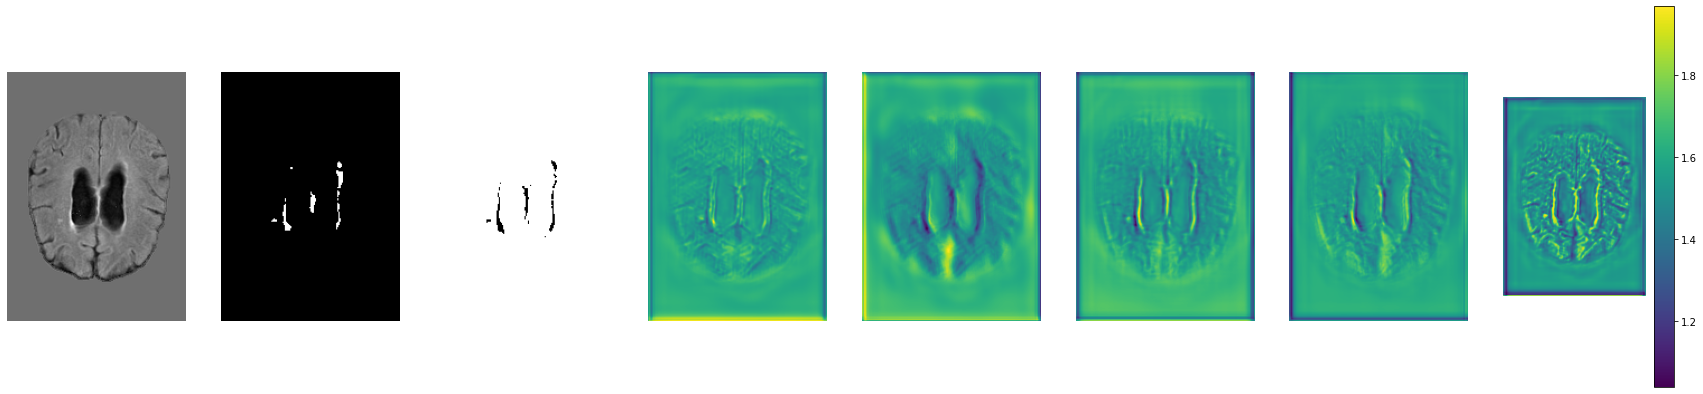

In [265]:
plt.figure(figsize=(30, 7))
N=8
def count_generator():
    count = 0
    while True:
        count += 1
        yield count
cg = count_generator()
counter  = lambda : next(cg)

plt.subplot(1,N,counter())
plt.imshow(x[18][0], cmap='gray');plt.axis('off')
plt.subplot(1,N,counter())
plt.imshow(y[18], cmap='gray');plt.axis('off')
plt.subplot(1,N,counter())
plt.imshow(mean[18].cpu().argmax(dim=0), cmap='binary');plt.axis('off')
plt.subplot(1,N,counter())
plt.imshow(features[18][0].cpu());plt.axis('off')
#plt.colorbar()
plt.subplot(1,N,counter())
plt.imshow(features[18][1].cpu());plt.axis('off')
#plt.colorbar()
plt.subplot(1,N,counter())
plt.imshow(features[18][2].cpu());plt.axis('off')
#plt.colorbar()
plt.subplot(1,N,counter())
plt.imshow(features[18][3].cpu());plt.axis('off')
#plt.colorbar();
plt.subplot(1,N,counter())
plt.imshow(tmap[18][1].cpu());plt.axis('off')
plt.colorbar();

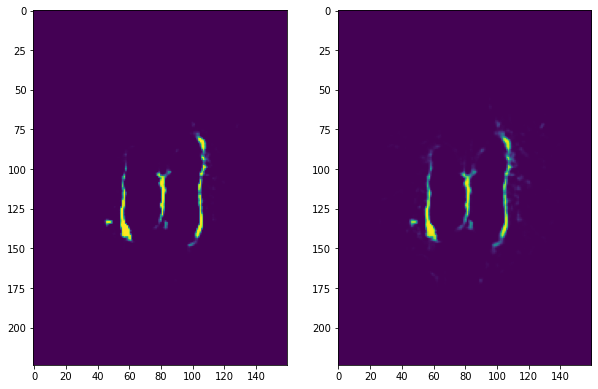

In [266]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(torch.nn.functional.softmax(mean[18], dim=0).cpu()[1])
plt.subplot(1,2,2)
plt.imshow(torch.nn.functional.softmax(scaled_mean[18], dim=0).cpu()[1])
# plt.imshow(torch.nn.functional.softmax(mean[18]/100, dim=0)[1])

In [267]:
def gen_samples(xs3dQ, ys3dQ):
    samples3d = []
    model_means3d = []
    
    i = best_model
    f = folders[i]
    c = cs[i]
    ckpt = root + f + c

    model = StandardLitModelWrapper.load_from_checkpoint(root + f + c, model=model_raw, loss=loss, 
                                logging_metric=SsnDiceMetricWrapper, strict=False).cuda()

    samples3d = []
    model = model.cuda()
    #temp_model = temp_model.cuda()
    for i in tqdm(range(len(ys3dQ)), position=0, leave=True, ncols=150):

        with torch.no_grad():
            out = model(xs3dQ[i].swapaxes(0,1).cuda())
            #samples = fixed_re_parametrization_trick(out['distribution'], 20).cpu() / tau
            samples = fixed_re_parametrization_trick(out['distribution'], 20)
            for i, s in enumerate(samples):
                samples[i] = temp_model.cuda()(s, from_pred=True)
            samples3d.append(samples.cpu())
            
            means = out['distribution'].mean
            means = temp_model.cuda()(means, from_pred=True)
            model_means3d.append(means.cpu())
            #model_means3d.append(out['distribution'].mean.cpu()/ tau) 
                
    return samples3d, model_means3d

In [268]:
samples3d, means3d = gen_samples(xs3d, ys3d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:25<00:00,  1.39it/s]


### Generating uncertainty maps for a batch


In [269]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

### Calibration

In [270]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [271]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [272]:
len(samples3d)

35

In [273]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx].squeeze()
    batch_samples = samples3d[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:23<00:00,  2.38s/it]


In [274]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [275]:
bin_accuracies

[0.0003017727576661855,
 0.0672285258769989,
 0.16050025820732117,
 0.25632545351982117,
 0.3532968759536743,
 0.45391950011253357,
 0.5593274831771851,
 0.6704491972923279,
 0.7842498421669006,
 0.8960677981376648,
 0.9592815637588501]

In [276]:
bin_confidences

[0.0004248878685757518,
 0.08685283362865448,
 0.19429922103881836,
 0.29670578241348267,
 0.3980233371257782,
 0.49911171197891235,
 0.5998694896697998,
 0.7010866403579712,
 0.8027800917625427,
 0.9071807265281677,
 0.9783499836921692]

In [277]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0255)


In [261]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0297)


In [92]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0377)


In [86]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0660)


AFTER CALIBRATION!!!


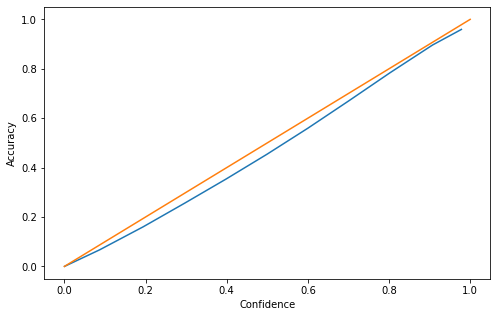

In [278]:
print("AFTER CALIBRATION!!!")


plt.figure(figsize=(8,5))
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
#save("calibration")

AFTER CALIBRATION!!!


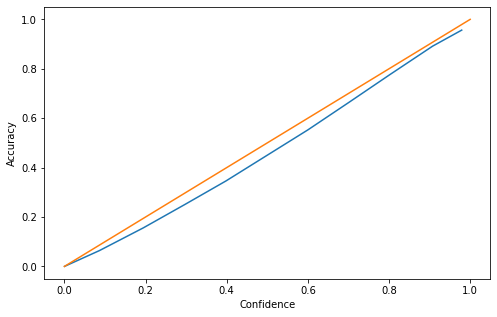

In [262]:
print("AFTER CALIBRATION!!!")


plt.figure(figsize=(8,5))
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
#save("calibration")

In [95]:
print("AFTER CALIBRATION!!!")

AFTER CALIBRATION!!!


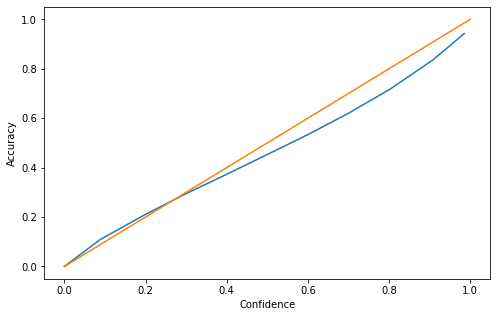

In [94]:

plt.figure(figsize=(8,5))
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
#save("calibration")

In [96]:
print("BEFORE CALIBRATION!!!")

BEFORE CALIBRATION!!!


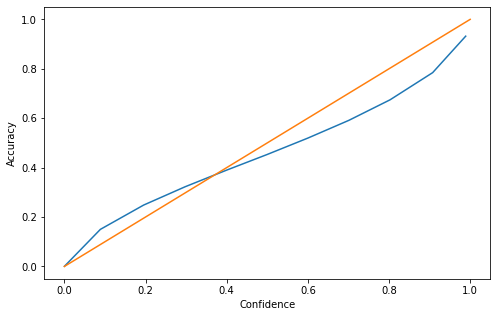

In [88]:

plt.figure(figsize=(8,5))
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
#save("calibration")